In [51]:
#Initial Imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import seaborn as sns
import hvplot.pandas
import json
import matplotlib.pyplot as plt
import plotly.express as px
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
import plotly.express as px
import numpy as np
%matplotlib inline

In [52]:
# Read Avocado_Historical.csv into dataframe, replace '.' as NaN and drop, change column to float, and set date as index
avo = pd.read_csv('./Data/Avocado_Historical.csv').replace('.', np.nan).dropna().astype({'WPU01110205': 'float'}).set_index('DATE').rename(columns={'WPU01110205': 'avo'})
# Format date
avo.index = pd.to_datetime(avo.index)
# Avocado historical price data
avo.index = avo.index.date
avo_plot = avo.hvplot(
    width=1000,
    height=500,
    title= 'Avocado Data',
    line_color= 'green',
    hover_line_color='lightgreen'
)
avo_plot

:Curve   [index]   (avo)

In [2]:
# Reading BTC prices
btc_path = Path("./Data/raw_btc_data.csv")
btc_df = pd.read_csv(btc_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
btc_df.head()

,Open,High,Low,Close,Adj_Close,Volume,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
Date,,,,,,,,,,
2014-09-17,465.86,468.17,452.42,457.33,457.33,21056800.0,NaN,NaN,NaN,NaN
2014-09-18,456.86,456.86,413.10,424.44,424.44,34483200.0,NaN,NaN,NaN,NaN
2014-09-19,424.10,427.83,384.53,394.80,394.80,37919700.0,NaN,NaN,NaN,NaN
2014-09-20,394.67,423.30,389.88,408.90,408.90,36863600.0,NaN,NaN,NaN,NaN
2014-09-21,408.08,412.43,393.18,398.82,398.82,26580100.0,NaN,NaN,NaN,NaN


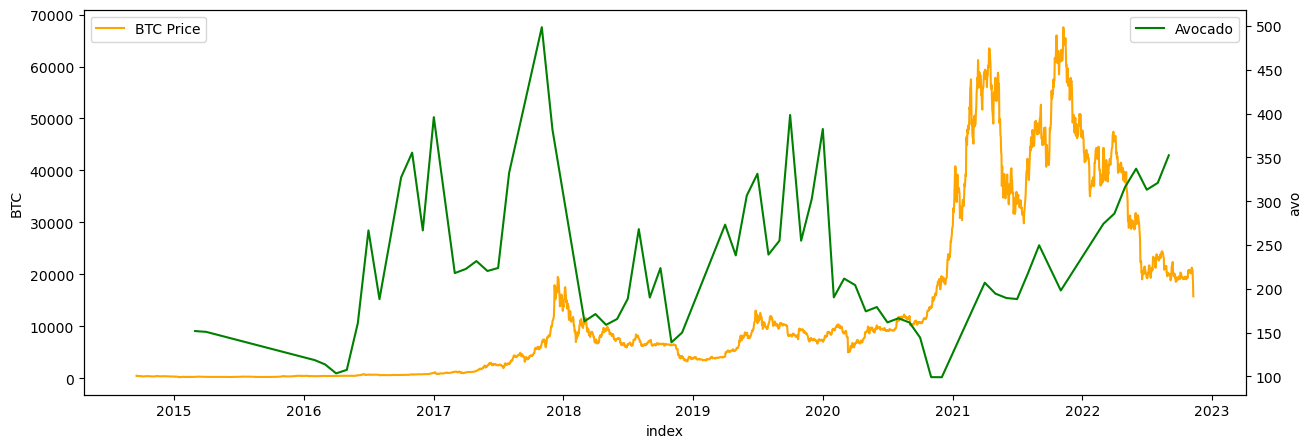

In [53]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(btc_df.index, btc_df.BTC, color='orange', label='BTC Price')
ax.set_xlabel('index')
ax.set_ylabel('BTC')
ax2 = ax.twinx()
ax2.plot(avo.index, avo.avo, color='green', label='Avocado')
ax2.set_ylabel('avo')
ax.legend(loc=2)
ax2.legend(loc=0)

In [3]:
btc_df = btc_df.drop(btc_df.columns[[0, 1, 2, 4, 5, 6, 7, 8, 9]], axis=1)
btc_df.columns = ['BTC']
btc_df.head()

,BTC
Date,
2014-09-17,457.33
2014-09-18,424.44
2014-09-19,394.80
2014-09-20,408.90
2014-09-21,398.82


In [4]:
from bokeh.models import HoverTool
hover = HoverTool(tooltips=[("amount", "@amount{0,0}"), ("local_date", "@local_date")]) 
btc_df.hvplot(height=500, width=1000, yformatter='%.0f', use_index=False).opts(tools=[hover])

bokeh backend could not plot any Elements in the Overlay.

:NdOverlay   [Variable]

In [5]:
from bokeh.models import HoverTool
hover = HoverTool(tooltips=[("BTC", "@BTC{0,0}"), ("Date", "@Date{%F}")], formatters={'@Date': 'datetime'})
btc_df.hvplot(
    width=1000,
    height=500,
    rot=90,
    yformatter='%.0f',
    title="BTC Historical Pricing"
).opts(tools=[hover])

:Curve   [Date]   (BTC)

In [6]:
#Import IYW CSV File
iyw_path = Path("./Data/IYW_US_Tech_ETF.csv")
iyw_df = pd.read_csv(iyw_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
iyw_df.head()

#Drop extra columns
iyw_df = iyw_df.drop(iyw_df.columns[[0, 1, 2, 4, 5]], axis=1)
iyw_df.columns = ['IYW']
iyw_df.head()

,IYW
Date,
2012-11-01,17.887501
2012-11-02,17.610001
2012-11-05,17.737499
2012-11-06,17.840000
2012-11-07,17.360001


In [7]:
#Import Gold CSV File
gold_path = Path("./Data/Gold_Historical.csv")
gold_df = pd.read_csv(gold_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
gold_df.columns = ['Gold']
gold_df.head()

,Gold
Date,
2012-11-11,1730.3
2012-11-12,1724.2
2012-11-13,1729.5
2012-11-14,1713.3
2012-11-15,1714.3


In [8]:
#Import SPY CSV File
spy_path = Path("./Data/SPY_Historical.csv")
spy_df = pd.read_csv(spy_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
spy_df.columns = ['SPY']
spy_df.head()

,SPY
Date,
2012-11-12,138.27
2012-11-13,137.79
2012-11-14,135.93
2012-11-15,135.70
2012-11-16,136.37


In [9]:
#Import Oil CSV File
oil_path = Path("./Data/WTI_Oil_Historical.csv")
oil_df = pd.read_csv(oil_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
oil_df.columns = ['Oil']
oil_df.head()

,Oil
Date,
2012-11-11,85.57
2012-11-12,85.38
2012-11-13,86.32
2012-11-14,85.45
2012-11-15,86.67


In [10]:
combined_df = pd.concat([btc_df, iyw_df, gold_df, spy_df, oil_df], axis="columns", join="inner")
combined_df

,BTC,IYW,Gold,SPY,Oil
Date,,,,,
2014-09-17,457.33,25.567499,1225.7,200.75,93.07
2014-09-18,424.44,25.732500,1215.3,201.82,92.41
2014-09-22,402.15,25.402500,1221.0,199.15,91.56
2014-09-23,435.79,25.347500,1218.6,198.01,92.80
2014-09-24,423.20,25.455000,1221.2,199.56,92.53
...,...,...,...,...,...
2022-10-24,19345.57,77.129997,1652.8,378.87,85.32
2022-10-25,20095.86,78.809998,1664.0,384.92,87.91
2022-10-26,20770.44,76.139999,1660.7,382.02,89.08


In [11]:
combined_returns = combined_df.pct_change()
combined_returns.dropna(inplace=True)
combined_returns

,BTC,IYW,Gold,SPY,Oil
Date,,,,,
2014-09-18,-0.071917,0.006454,-0.008485,0.005330,-0.007091
2014-09-22,-0.052516,-0.012824,0.004690,-0.013230,-0.009198
2014-09-23,0.083650,-0.002165,-0.001966,-0.005724,0.013543
2014-09-24,-0.028890,0.004241,0.002134,0.007828,-0.002909
2014-09-25,-0.027481,-0.023571,-0.005814,-0.016135,0.010915
...,...,...,...,...,...
2022-10-24,0.015316,0.035441,0.001090,0.036835,0.003175
2022-10-25,0.038784,0.021781,0.006776,0.015969,0.030356
2022-10-26,0.033568,-0.033879,-0.001983,-0.007534,0.013309


In [12]:
combined_returns.hvplot(
    width=1000,
    height=500,
    rot=90,
    yformatter='%.0f',
    title="Combined Historical Returns"
).opts(tools=[hover])

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

<AxesSubplot:title={'center':'Combined Historical Returns'}, xlabel='Date'>

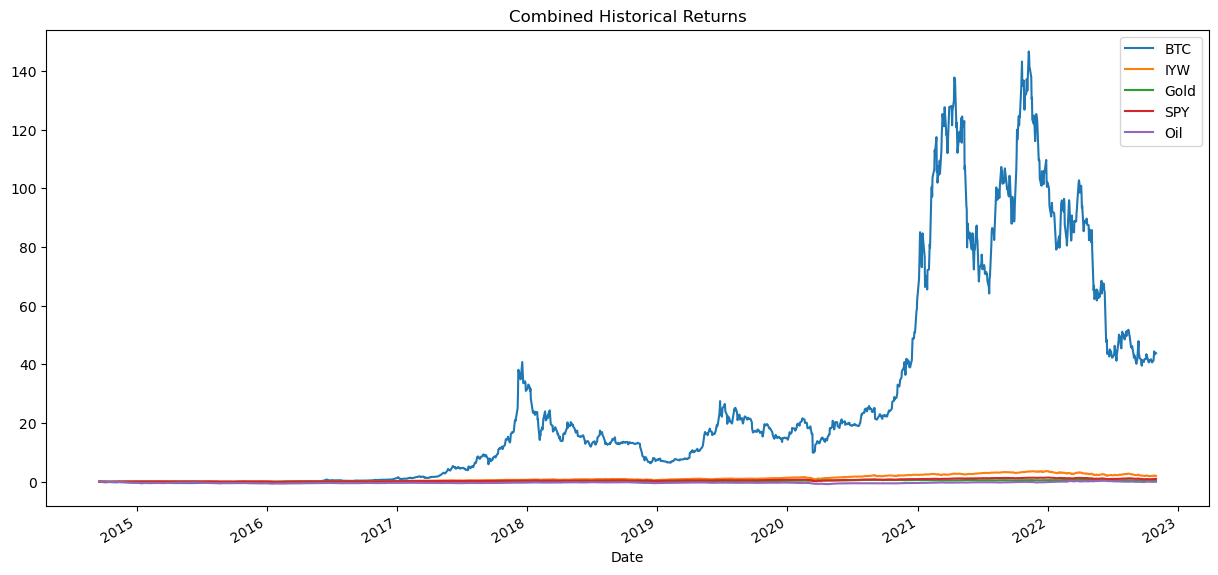

In [13]:
# Calculate cumulative returns of all portfolios
combined_cumu_returns = (1 + combined_returns).cumprod() - 1
combined_cumu_returns

# Plot cumulative returns
combined_cumu_returns.plot(figsize=(15,7), title = "Combined Historical Returns")

<AxesSubplot:xlabel='Date'>

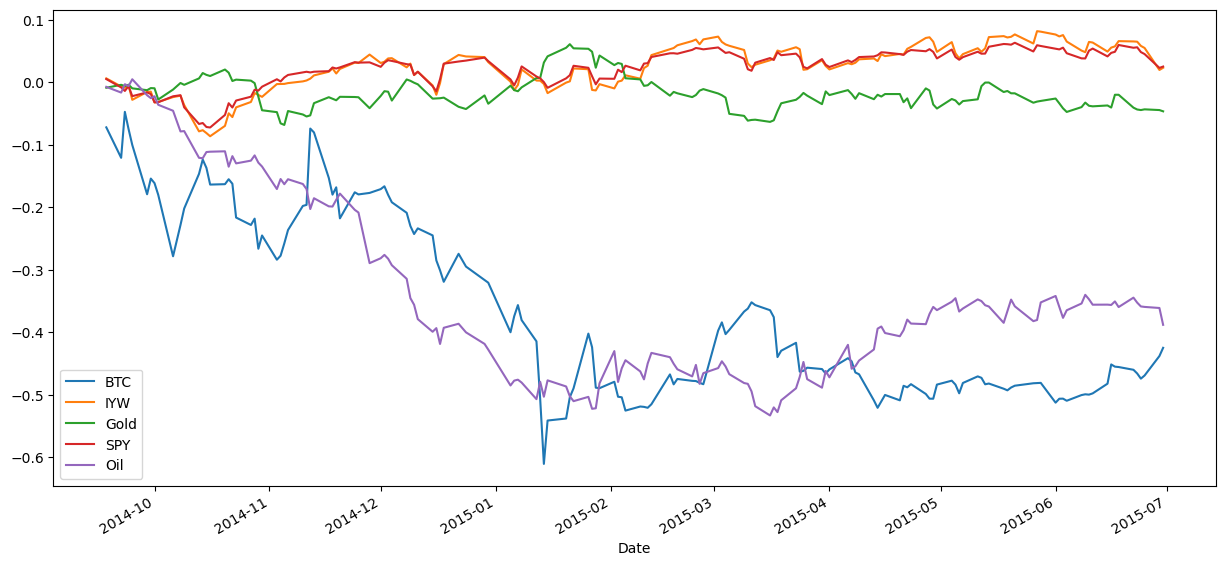

In [14]:
# Calculate cumulative returns of all portfolios during first Analysis Time Period
start_date_1 = '2014-9-15'
end_date_1 = '2015-06-30'

combined_returns_1 = combined_returns.loc[start_date_1:end_date_1]
combined_returns_1

combined_cumu_returns_1 = (1 + combined_returns_1).cumprod() - 1
combined_cumu_returns_1

# Plot cumulative returns
combined_cumu_returns_1.plot(figsize=(15,7))

<AxesSubplot:xlabel='Date'>

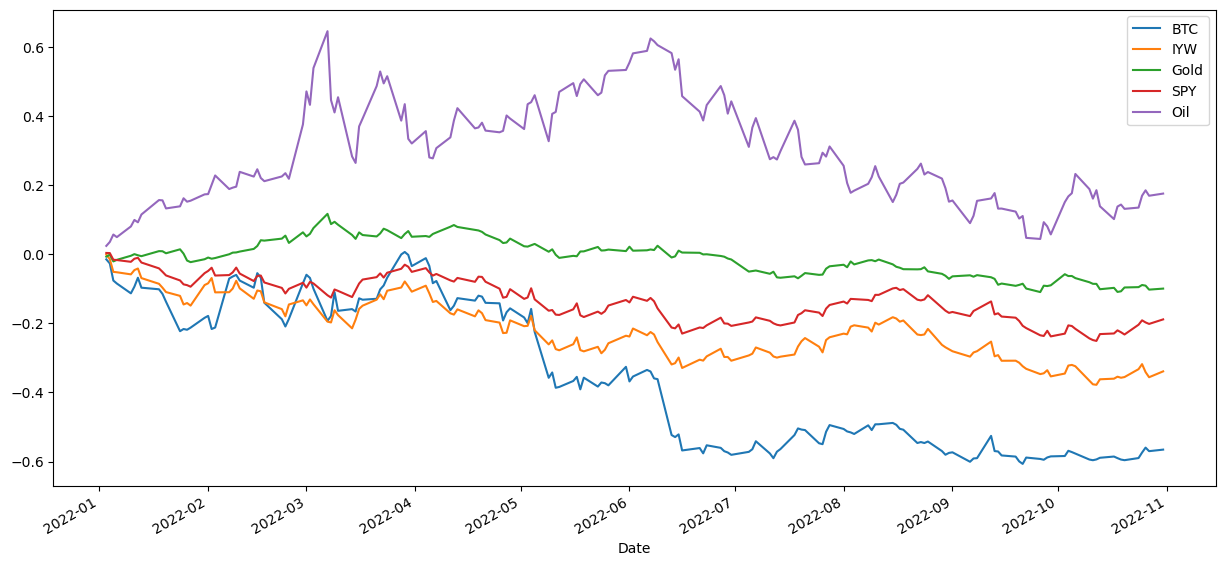

In [54]:
# Calculate cumulative returns of all portfolios during second Analysis Time Period
start_date_2 = '2022-01-03'
end_date_2 = '2022-10-31'

combined_returns_2 = combined_returns.loc[start_date_2:end_date_2]
combined_returns_2

combined_cumu_returns_2 = (1 + combined_returns_2).cumprod() - 1
combined_cumu_returns_2

# Plot cumulative returns
combined_cumu_returns_2.plot(figsize=(15,7))

<AxesSubplot:>

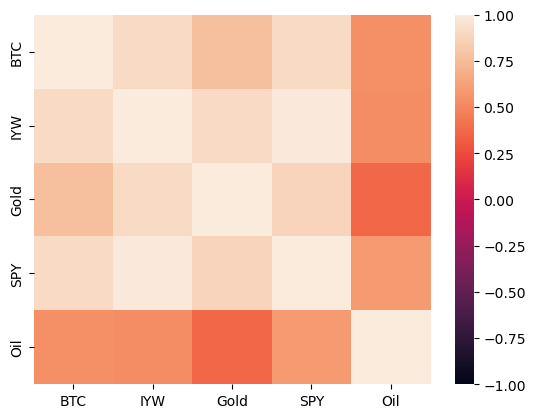

In [16]:
# Calculate the correlation of closing prices between MSFT and SP500
combined_correlation = combined_cumu_returns.corr()

# Use the `heatmap` function from the seaborn library to visualize correlations
sns.heatmap(combined_correlation, vmin=-1, vmax=1)

In [17]:
combined_correlation

,BTC,IYW,Gold,SPY,Oil
BTC,1.000000,0.911731,0.768250,0.908296,0.537262
IYW,0.911731,1.000000,0.912357,0.991481,0.529479
Gold,0.768250,0.912357,1.000000,0.881963,0.362547
SPY,0.908296,0.991481,0.881963,1.000000,0.591723
Oil,0.537262,0.529479,0.362547,0.591723,1.000000


In [18]:
# Calculate covariance of all daily returns of MSFT vs. AAPL
covariance = combined_returns['BTC'].cov(combined_returns['IYW'])
covariance

0.00019238286884262692

In [19]:
# Calculate variance of the S&P 500
variance = combined_returns['BTC'].var()
variance

0.002705662341212161

In [20]:
iyw_beta = covariance / variance
iyw_beta

0.07110379810232996

In [21]:
btc_df2 = pd.read_csv(btc_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
btc_df2 = btc_df2.drop(btc_df2.columns[[0, 1, 4, 5, 6, 7, 8, 9]], axis=1)
btc_df2.columns = ['BTC_Low','BTC_Close']
btc_df2.head()

,BTC_Low,BTC_Close
Date,,
2014-09-17,452.42,457.33
2014-09-18,413.10,424.44
2014-09-19,384.53,394.80
2014-09-20,389.88,408.90
2014-09-21,393.18,398.82


In [22]:
# build payload
kw_list = ["Bitcoin"]
pytrends.build_payload(kw_list, cat=0, timeframe='2020-03-09 2020-03-19')

In [23]:
data_1_df = pytrends.interest_over_time()
data_1_df = data_1_df.reset_index()
fig = px.line(data_1_df, x="date", y=['Bitcoin'], title='Bitcoin Search Over Time')
fig.show()

In [24]:
#data1_df = pytrends.interest_over_time()
data_1_df = data_1_df.set_index("date")
data_1_df = data_1_df.drop(data_1_df.columns[[1]], axis=1)
data_1_df.columns = ['BTC_Searches']
data_1_df

,BTC_Searches
date,
2020-03-09,55
2020-03-10,43
2020-03-11,36
2020-03-12,76
2020-03-13,100
2020-03-14,67
2020-03-15,58
2020-03-16,74
2020-03-17,62


In [25]:
spike_1_df = pd.concat([data_1_df, btc_df2], axis="columns", join="inner")
#spike_1_df.plot()
spike_1_df

,BTC_Searches,BTC_Low,BTC_Close
2020-03-09,55,7690.10,7923.64
2020-03-10,43,7814.76,7909.73
2020-03-11,36,7642.81,7911.43
2020-03-12,76,4860.35,4970.79
2020-03-13,100,4106.98,5563.71
2020-03-14,67,5125.07,5200.37
2020-03-15,58,5169.28,5392.31
2020-03-16,74,4575.36,5014.48
2020-03-17,62,4981.91,5225.63
2020-03-18,56,5069.34,5238.44


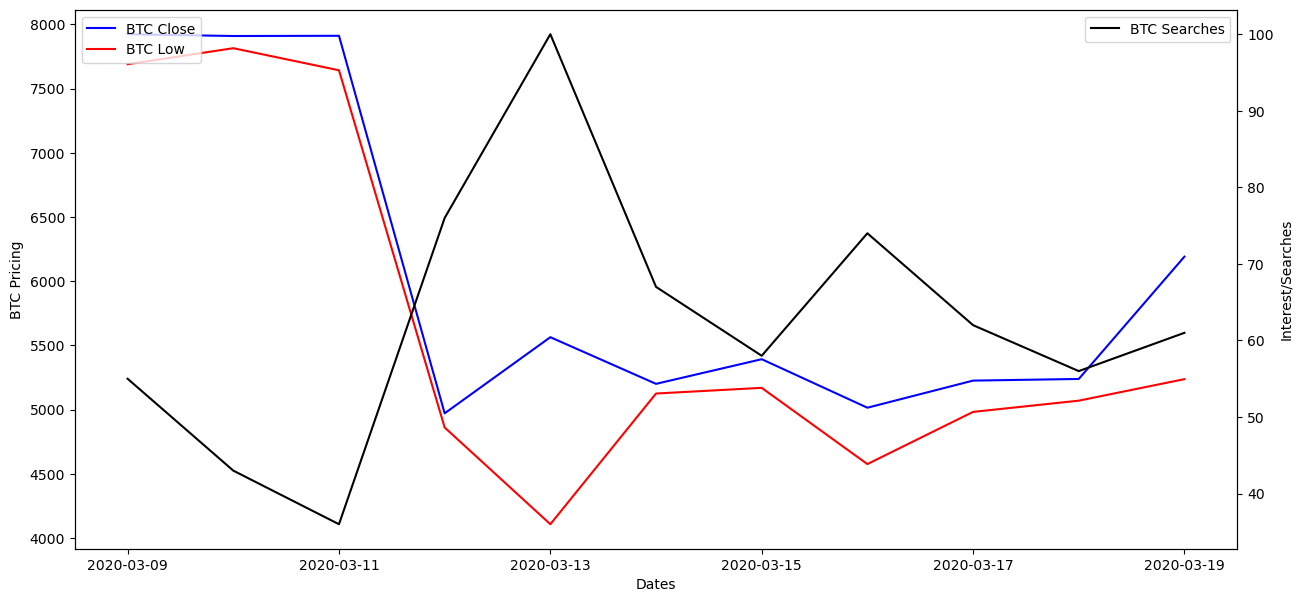

In [26]:
# Combine BTC search, btc price and plot
fig,ax = plt.subplots(figsize=(15,7))
ax.plot(spike_1_df.index, spike_1_df.BTC_Close, color='blue', label='BTC Close')
ax.plot(spike_1_df.index, spike_1_df.BTC_Low, color='red', label='BTC Low')
ax.set_xlabel('Dates')
ax.set_ylabel('BTC Pricing')
ax2 = ax.twinx()
ax2.plot(spike_1_df.index, spike_1_df.BTC_Searches, color='black', label='BTC Searches')
ax2.set_ylabel('Interest/Searches')
ax.legend(loc=2)
ax2.legend(loc=0)

In [30]:
# build payload
kw_list = ["Bitcoin"]
pytrends.build_payload(kw_list, cat=0, timeframe='2021-02-05 2021-02-15')

data_2_df = pytrends.interest_over_time()
data_2_df = data_2_df.reset_index()
fig = px.line(data_2_df, x="date", y=['Bitcoin'], title='Bitcoin Search Over Time')
fig.show()

In [32]:
data_2_df = data_2_df.set_index("date")
data_2_df = data_2_df.drop(data_2_df.columns[[1]], axis=1)
data_2_df.columns = ['BTC_Searches']
data_2_df

,BTC_Searches
date,
2021-02-05,37
2021-02-06,43
2021-02-07,39
2021-02-08,82
2021-02-09,100
2021-02-10,68
2021-02-11,59
2021-02-12,59
2021-02-13,49


In [33]:
spike_2_df = pd.concat([data_2_df, btc_df2], axis="columns", join="inner")
spike_2_df

,BTC_Searches,BTC_Low,BTC_Close
2021-02-05,37,36658.76,38144.31
2021-02-06,43,38138.39,39266.01
2021-02-07,39,37446.15,38903.44
2021-02-08,82,38076.32,46196.46
2021-02-09,100,45166.96,46481.11
2021-02-10,68,43881.15,44918.18
2021-02-11,59,44187.76,47909.33
2021-02-12,59,46424.98,47504.85
2021-02-13,49,46392.28,47105.52
2021-02-14,54,47114.51,48717.29


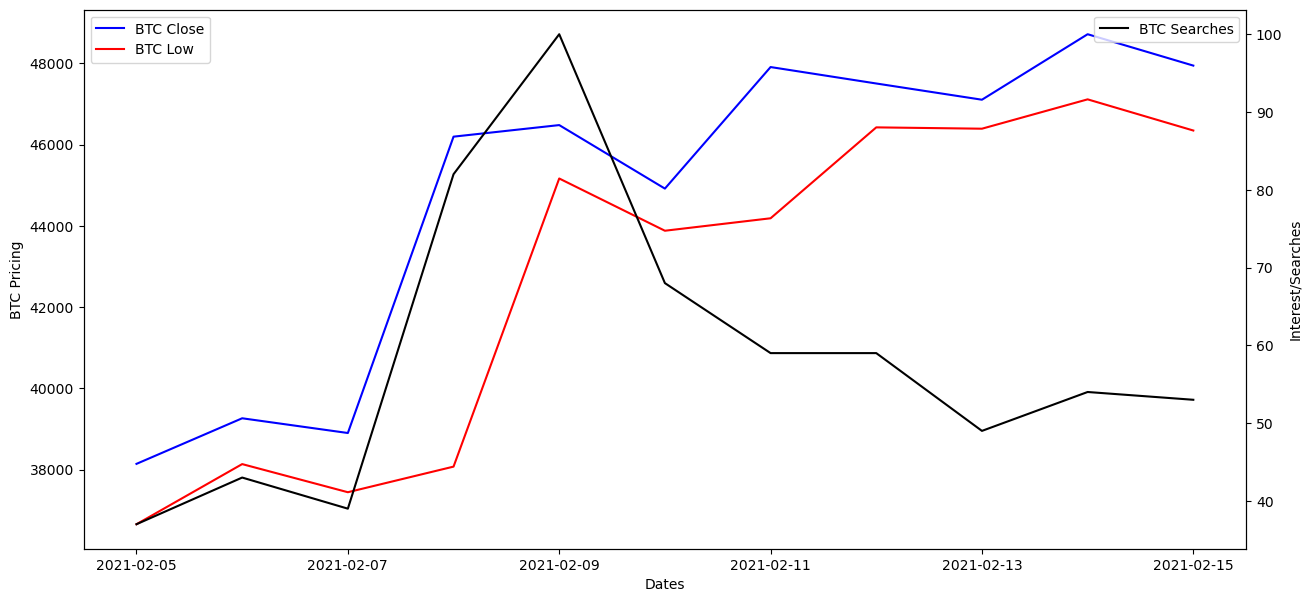

In [34]:
# Combine BTC search, btc price and plot
fig,ax = plt.subplots(figsize=(15,7))
ax.plot(spike_2_df.index, spike_2_df.BTC_Close, color='blue', label='BTC Close')
ax.plot(spike_2_df.index, spike_2_df.BTC_Low, color='red', label='BTC Low')
ax.set_xlabel('Dates')
ax.set_ylabel('BTC Pricing')
ax2 = ax.twinx()
ax2.plot(spike_2_df.index, spike_2_df.BTC_Searches, color='black', label='BTC Searches')
ax2.set_ylabel('Interest/Searches')
ax.legend(loc=2)
ax2.legend(loc=0)

In [35]:
# build payload
kw_list = ["Bitcoin"]
pytrends.build_payload(kw_list, cat=0, timeframe='2021-05-10 2021-05-18')

data_3_df = pytrends.interest_over_time()
data_3_df = data_3_df.reset_index()
fig = px.line(data_3_df, x="date", y=['Bitcoin'], title='Bitcoin Search Over Time')
fig.show()

In [36]:
data_3_df = data_3_df.set_index("date")
data_3_df = data_3_df.drop(data_3_df.columns[[1]], axis=1)
data_3_df.columns = ['BTC_Searches']
#data_3_df

spike_3_df = pd.concat([data_3_df, btc_df2], axis="columns", join="inner")
spike_3_df

,BTC_Searches,BTC_Low,BTC_Close
2021-05-10,41,54071.46,55859.80
2021-05-11,38,54608.65,56704.57
2021-05-12,41,49150.54,49150.54
2021-05-13,100,46980.02,49716.19
2021-05-14,64,48868.58,49880.54
2021-05-15,49,46664.14,46760.19
2021-05-16,53,43963.35,46456.06
2021-05-17,76,42207.29,43537.51
2021-05-18,59,42367.83,42909.40


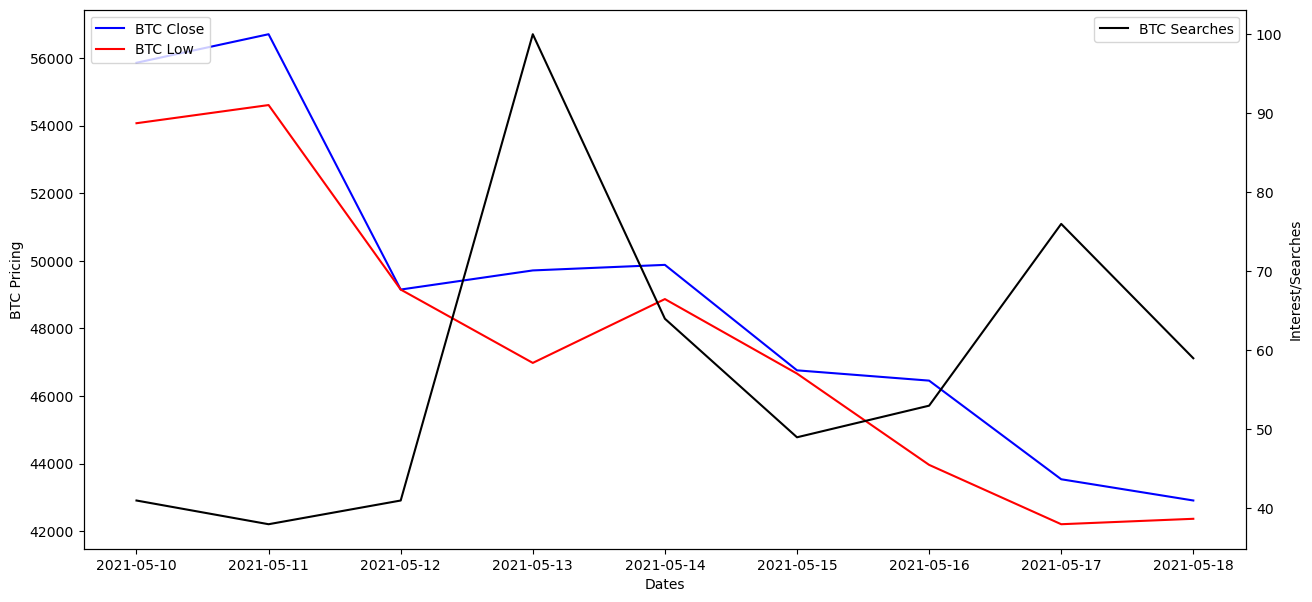

In [40]:
# Combine BTC search, btc price and plot
fig,ax = plt.subplots(figsize=(15,7))
ax.plot(spike_3_df.index, spike_3_df.BTC_Close, color='blue', label='BTC Close')
ax.plot(spike_3_df.index, spike_3_df.BTC_Low, color='red', label='BTC Low')
ax.set_xlabel('Dates')
ax.set_ylabel('BTC Pricing')
ax2 = ax.twinx()
ax2.plot(spike_3_df.index, spike_3_df.BTC_Searches, color='black', label='BTC Searches')
ax2.set_ylabel('Interest/Searches')
ax.legend(loc=2)
ax2.legend(loc=0)

In [41]:
# build payload
kw_list = ["Bitcoin"]
pytrends.build_payload(kw_list, cat=0, timeframe='2021-05-17 2021-05-24')

data_4_df = pytrends.interest_over_time()
data_4_df = data_4_df.reset_index()
fig = px.line(data_4_df, x="date", y=['Bitcoin'], title='Bitcoin Search Over Time')
fig.show()

In [42]:
data_4_df = data_4_df.set_index("date")
data_4_df = data_4_df.drop(data_4_df.columns[[1]], axis=1)
data_4_df.columns = ['BTC_Searches']
#data_3_df

spike_4_df = pd.concat([data_4_df, btc_df2], axis="columns", join="inner")
spike_4_df

,BTC_Searches,BTC_Low,BTC_Close
2021-05-17,51,42207.29,43537.51
2021-05-18,40,42367.83,42909.40
2021-05-19,100,30681.50,37002.44
2021-05-20,76,35050.62,40782.74
2021-05-21,57,33616.45,37304.69
2021-05-22,51,35383.68,37536.63
2021-05-23,59,31227.34,34770.58
2021-05-24,54,34551.08,38705.98


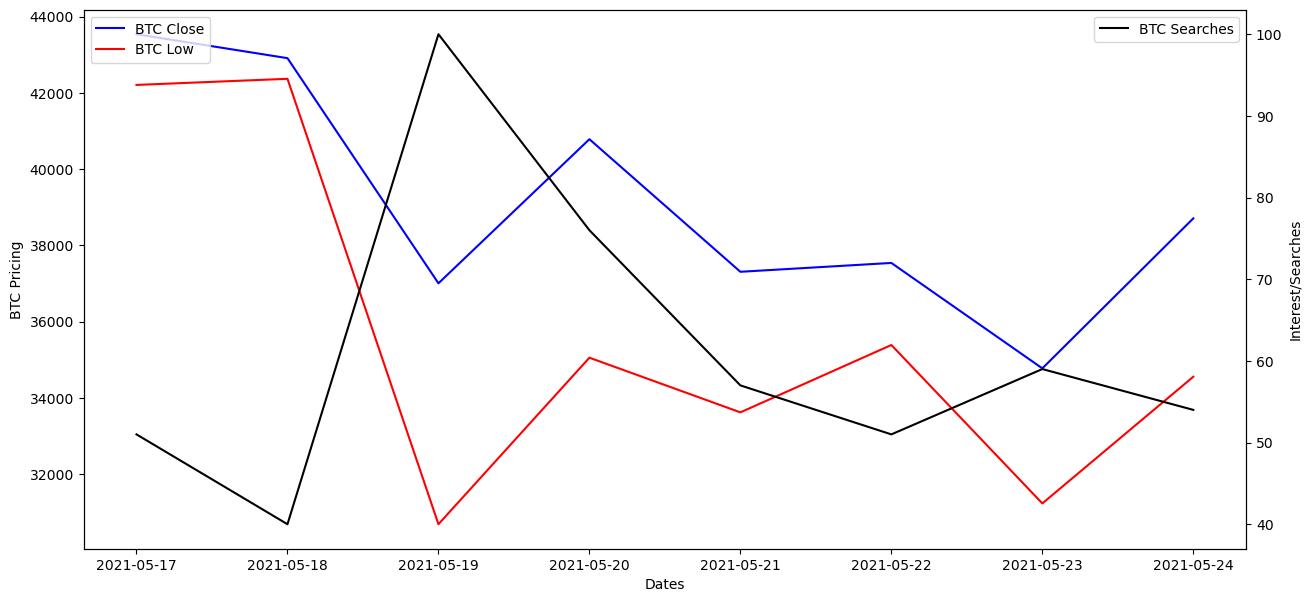

In [43]:
# Combine BTC search, btc price and plot
fig,ax = plt.subplots(figsize=(15,7))
ax.plot(spike_4_df.index, spike_4_df.BTC_Close, color='blue', label='BTC Close')
ax.plot(spike_4_df.index, spike_4_df.BTC_Low, color='red', label='BTC Low')
ax.set_xlabel('Dates')
ax.set_ylabel('BTC Pricing')
ax2 = ax.twinx()
ax2.plot(spike_4_df.index, spike_4_df.BTC_Searches, color='black', label='BTC Searches')
ax2.set_ylabel('Interest/Searches')
ax.legend(loc=2)
ax2.legend(loc=0)

In [44]:
# build payload
kw_list = ["Bitcoin"]
pytrends.build_payload(kw_list, cat=0, timeframe='2021-12-02 2021-12-14')

data_5_df = pytrends.interest_over_time()
data_5_df = data_5_df.reset_index()
fig = px.line(data_5_df, x="date", y=['Bitcoin'], title='Bitcoin Search Over Time')
fig.show()

In [45]:
data_5_df = data_5_df.set_index("date")
data_5_df = data_5_df.drop(data_5_df.columns[[1]], axis=1)
data_5_df.columns = ['BTC_Searches']

spike_5_df = pd.concat([data_5_df, btc_df2], axis="columns", join="inner")
spike_5_df

,BTC_Searches,BTC_Low,BTC_Close
2021-12-02,42,55895.13,56477.82
2021-12-03,42,52496.59,53598.25
2021-12-04,100,42874.62,49200.70
2021-12-05,67,47857.50,49368.85
2021-12-06,67,47281.04,50582.63
2021-12-07,61,50175.81,50700.09
2021-12-08,54,48765.99,50504.80
2021-12-09,49,47358.35,47672.12
2021-12-10,49,47023.70,47243.30
2021-12-11,44,46942.35,49362.51


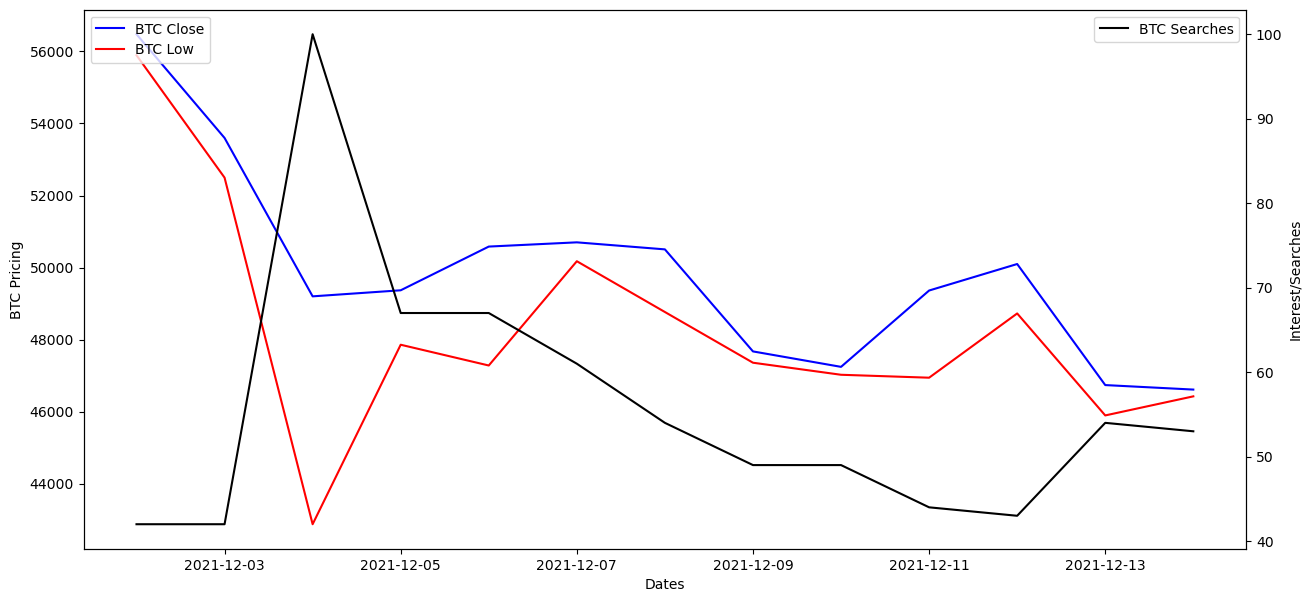

In [46]:
# Combine BTC search, btc price and plot
fig,ax = plt.subplots(figsize=(15,7))
ax.plot(spike_5_df.index, spike_5_df.BTC_Close, color='blue', label='BTC Close')
ax.plot(spike_5_df.index, spike_5_df.BTC_Low, color='red', label='BTC Low')
ax.set_xlabel('Dates')
ax.set_ylabel('BTC Pricing')
ax2 = ax.twinx()
ax2.plot(spike_5_df.index, spike_5_df.BTC_Searches, color='black', label='BTC Searches')
ax2.set_ylabel('Interest/Searches')
ax.legend(loc=2)
ax2.legend(loc=0)

In [47]:
# build payload
kw_list = ["Bitcoin"]
pytrends.build_payload(kw_list, cat=0, timeframe='2022-06-10 2022-06-19')

data_6_df = pytrends.interest_over_time()
data_6_df = data_6_df.reset_index()
fig = px.line(data_6_df, x="date", y=['Bitcoin'], title='Bitcoin Search Over Time')
fig.show()

In [48]:
data_6_df = data_6_df.set_index("date")
data_6_df = data_6_df.drop(data_6_df.columns[[1]], axis=1)
data_6_df.columns = ['BTC_Searches']

spike_6_df = pd.concat([data_6_df, btc_df2], axis="columns", join="inner")
spike_6_df

,BTC_Searches,BTC_Low,BTC_Close
2022-06-10,29,28978.15,29083.80
2022-06-11,29,28236.21,28360.81
2022-06-12,37,26762.65,26762.65
2022-06-13,100,22141.26,22487.39
2022-06-14,98,20950.82,22206.79
2022-06-15,88,20178.38,22572.84
2022-06-16,75,20265.23,20381.65
2022-06-17,66,20326.52,20471.48
2022-06-18,95,17708.62,19017.64
2022-06-19,93,18067.15,20553.27


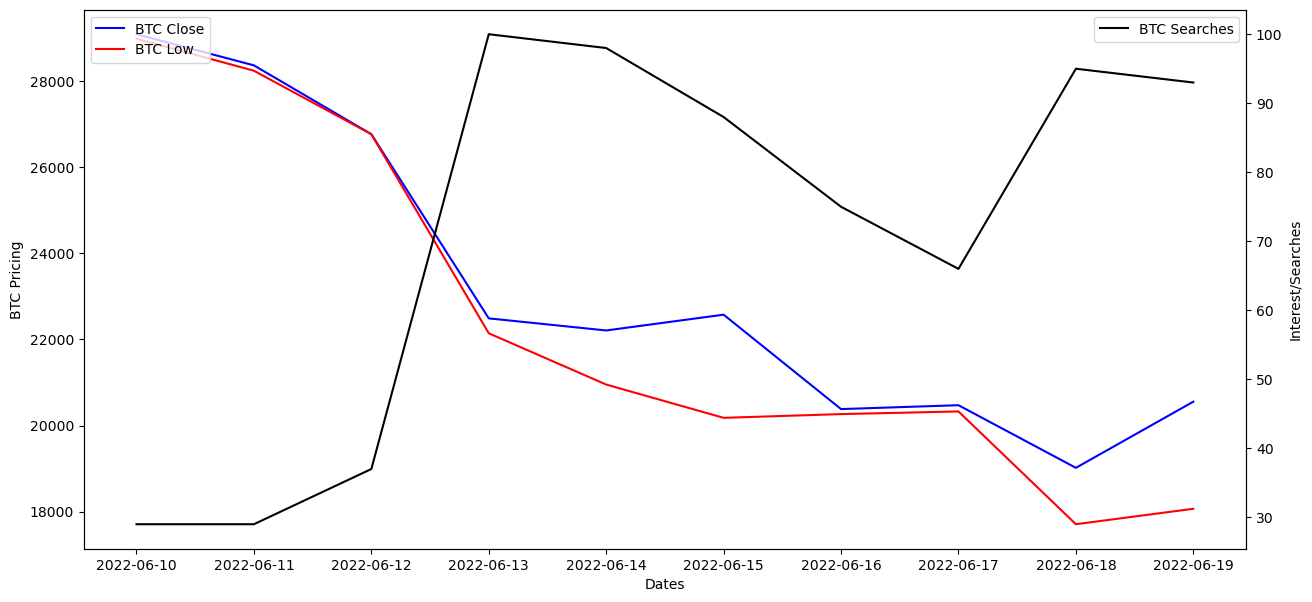

In [49]:
# Combine BTC search, btc price and plot
fig,ax = plt.subplots(figsize=(15,7))
ax.plot(spike_6_df.index, spike_6_df.BTC_Close, color='blue', label='BTC Close')
ax.plot(spike_6_df.index, spike_6_df.BTC_Low, color='red', label='BTC Low')
ax.set_xlabel('Dates')
ax.set_ylabel('BTC Pricing')
ax2 = ax.twinx()
ax2.plot(spike_6_df.index, spike_6_df.BTC_Searches, color='black', label='BTC Searches')
ax2.set_ylabel('Interest/Searches')
ax.legend(loc=2)
ax2.legend(loc=0)